In [1]:
import pandas as pd

houses_df = pd.read_csv("kc_house_data.csv")
#disregarding theses columns from the original Dataset
houses_df = houses_df.drop(columns = ['sqft_above', 'zipcode','lat', 'long','sqft_living15', 'sqft_lot15']).reset_index(drop= True)
houses_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,0,1955,0
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,400,1951,1991
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,0,1933,0
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,910,1965,0
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,0,1987,0


In [2]:
houses_df.shape # (no. of rows, no. of columns)

(21613, 15)

In [3]:
#finding null values
print(houses_df.isna().sum())

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_basement    0
yr_built         0
yr_renovated     0
dtype: int64


In [4]:
#extracting relevant numeric values 
houses_df_numeric = houses_df[['id','price', 'bedrooms', 'bathrooms', 'sqft_living','sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade','sqft_basement']]
#display the min and max values of each column
houses_df_numeric.agg(['min', 'max'])


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement
min,1000102,75000.0,0,0.0,290,520,1.0,0,0,1,1,0
max,9900000190,7700000.0,33,8.0,13540,1651359,3.5,1,4,5,13,4820


In [5]:
#the max value of floors is 3.5, which is invalid as all these numbers must be integer by definition
#checking other columns that can't have decimal values
import numpy as np
cols_to_check = ['bathrooms','bedrooms', 'floors']
condition = houses_df_numeric[cols_to_check] % 1 != 0
fractional_rows = houses_df_numeric.loc[condition.any(axis=1)].copy()
assert fractional_rows.index.isin(houses_df_numeric.index).all(), "Indices misaligned!"

#adding id for display only
display_cols = ['id']+ cols_to_check  

#printing some of the rows that contain fractions
fractional_rows[display_cols].head(100)


,id,bathrooms,bedrooms,floors
1,6414100192,2.25,3,2.0
5,7237550310,4.50,4,1.0
6,1321400060,2.25,3,2.0
7,2008000270,1.50,3,1.0
9,3793500160,2.50,3,2.0
...,...,...,...,...
126,4058801670,2.25,3,1.0
127,8732020310,2.25,4,1.0
128,2331300505,3.50,5,2.0
129,7853210060,2.50,4,2.0


In [6]:
# flooring the decimal results to the nearest integer
fractional_rows_floored = fractional_rows.copy()
fractional_rows_floored[cols_to_check] = np.floor( fractional_rows[cols_to_check])
fractional_rows_floored[display_cols].head(100)

,id,bathrooms,bedrooms,floors
1,6414100192,2.0,3.0,2.0
5,7237550310,4.0,4.0,1.0
6,1321400060,2.0,3.0,2.0
7,2008000270,1.0,3.0,1.0
9,3793500160,2.0,3.0,2.0
...,...,...,...,...
126,4058801670,2.0,3.0,1.0
127,8732020310,2.0,4.0,1.0
128,2331300505,3.0,5.0,2.0
129,7853210060,2.0,4.0,2.0


In [7]:
# creating backup before using update()
houses_df_backup = houses_df.copy()
houses_df_numeric_backup = houses_df_numeric.copy()

#updating our dataFrames
houses_df_numeric.update(fractional_rows_floored[cols_to_check])
houses_df.update(houses_df_numeric[['id']+cols_to_check])

print(houses_df[display_cols])


               id  bathrooms  bedrooms  floors
0      7129300520        1.0         3     1.0
1      6414100192        2.0         3     2.0
2      5631500400        1.0         2     1.0
3      2487200875        3.0         4     1.0
4      1954400510        2.0         3     1.0
...           ...        ...       ...     ...
21608   263000018        2.0         3     3.0
21609  6600060120        2.0         4     2.0
21610  1523300141        0.0         2     2.0
21611   291310100        2.0         3     2.0
21612  1523300157        0.0         2     2.0

[21613 rows x 4 columns]


In [8]:
#finding and discarding outliers using zscores
# z-score --> how far a point is from the mean in std_deviation points ex: price is 3 std_deviations away from the mean.
from scipy import stats
zscores_df = pd.DataFrame(stats.zscore(houses_df_numeric),columns=houses_df_numeric.columns,index=houses_df_numeric.index ).abs()

# #this is a statistical rule of thumb, that if a data is 3 std_deviations (or more) above or below the mean, it is considered an outlier
threshold = 3
outliers = (zscores_df > threshold).any(axis=1)

# #backup our dataset
houses_df_backup = houses_df.copy()
houses_df_numeric_backup = houses_df_numeric_backup.copy() 

# #removing outliers
houses_df = houses_df.loc[~outliers].copy()
houses_df_numeric = houses_df_numeric.loc[~outliers].copy()

assert houses_df.index.equals(houses_df_numeric.index), "Indices misaligned!"

print(f"number rows with outlier values : {houses_df_backup.loc[outliers].shape[0]}")
print(f"rows before cleaning: {houses_df_backup.shape[0]} rows after cleaning: {houses_df.shape[0]}")


number rows with outlier values : 1843
rows before cleaning: 21613 rows after cleaning: 19770


In [9]:
houses_df['date'] = pd.to_datetime(houses_df['date'], format='%Y%m%dT%H%M%S')

#find the correlation between each feature and price feature

corr_df = houses_df.copy()
#add is_renovated column for processing
corr_df['is_renovated'] = (corr_df['yr_renovated'] != 0).astype(int)
corr_features= ['is_renovated','grade','condition','yr_built','view','floors','bedrooms','bathrooms','sqft_living','waterfront','sqft_basement','price']
corr_df = corr_df[corr_features]

corr = corr_df.corr()
print(corr['price'].sort_values(ascending=False))

price            1.000000
grade            0.640864
sqft_living      0.628892
bathrooms        0.411065
bedrooms         0.305941
floors           0.252788
sqft_basement    0.215123
view             0.194860
is_renovated     0.089123
yr_built         0.046325
condition        0.038136
waterfront            NaN
Name: price, dtype: float64


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


#removing 'price' from the features given to the model, so that it doesn't give perfect results
#remove poorly correlated features to avoid noise
reg_features = ['grade', 'sqft_living', 'bathrooms', 'bedrooms', 'floors', 'sqft_basement', 'view']

X = houses_df[reg_features] 
y = houses_df['price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#scale to avoid overfitting
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#build model
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)
y_pred = linreg.predict(X_test_scaled)

# evaluation results
# Mean Squared Error 
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# R2 Score 
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2:.2f}")

Mean Squared Error: 28416963307.54
R2 Score: 0.50


In [11]:
#improving the linear regression results using feature engineering
import numpy as np
#new feature to measure age of house
houses_df['age_of_house'] = 2025 - houses_df['yr_built']
houses_df['price_per_sqft']  = houses_df['price'] /houses_df['sqft_living']
#using log of price instead of price
houses_df['log_price'] = np.log(houses_df['price'])

# testing to turn the condition and view into a boolean rather than a scale
houses_df['good_condition'] = (houses_df['condition'] >= 3).astype(int)	
houses_df['good_view'] = (houses_df['view'] >= 2).astype(int)

reg_features = ['grade', 'sqft_living', 'bathrooms', 'bedrooms', 'floors', 'sqft_basement','good_condition', 'good_view','age_of_house','price_per_sqft' ]

X = houses_df[reg_features]
y = houses_df['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#scale to avoid overfitting
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)
y_pred = linreg.predict(X_test_scaled)

# Mean Squared Error 
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# R2 Score 
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2:.2f}")

Mean Squared Error: 0.02
R2 Score: 0.93


/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(


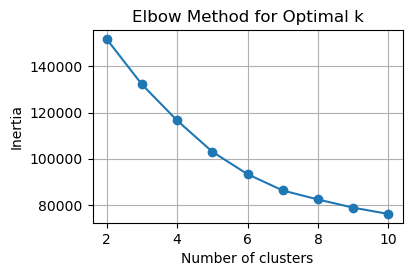

In [12]:
#apply elbow method to determine the  best k value
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

features = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
            'waterfront', 'view', 'condition', 'grade', 'sqft_basement']


X = houses_df[features]

#scaling to z_scores to ensure no dominance to any feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # 2D array containg zscore value of each cell

# intertia represents how close points are to the center of the cluster. calculated for each k number of clusters.
# random_states = 42 just sets a seed for the random centeroid point.
# n_init tries 10 different random starts, picks the lowest intertia.
inertia = [] 
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(4, 2.5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


        price  bedrooms  bathrooms  sqft_living  sqft_lot    floors  \
PC1  0.394498  0.330216   0.414395     0.484687  0.094584  0.289996   
PC2  0.125406  0.208088  -0.108763     0.121874  0.174021 -0.516109   

     waterfront      view  condition     grade  sqft_basement  
PC1        -0.0  0.100168   -0.08523  0.447133       0.135699  
PC2        -0.0  0.213377    0.47884 -0.127657       0.571422  


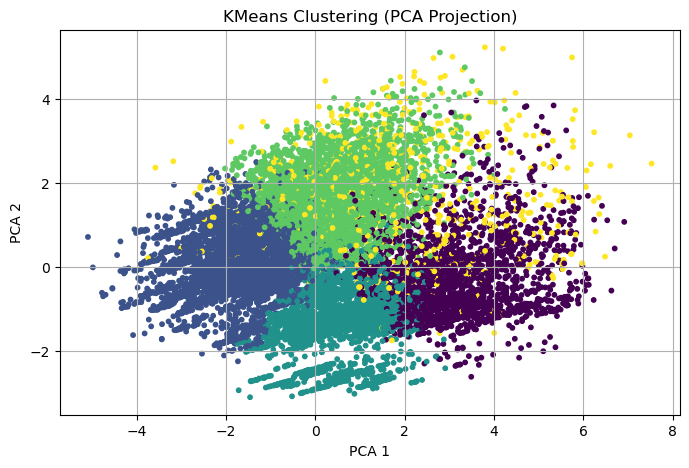

In [13]:
#from the visualization above, we can deduce the optimal number of clusters :  5
n_clusters = 5
kmeans = KMeans(n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)


houses_df['cluster'] = clusters
assert len(clusters) == len(houses_df), "Cluster labels misaligned!"

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_components = pd.DataFrame(
    pca.components_, 
    columns=features,  # Your original feature names (price, bedrooms, etc.)
    index=['PC1', 'PC2']
)

print(pca_components)

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=10)
plt.title('KMeans Clustering (PCA Projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

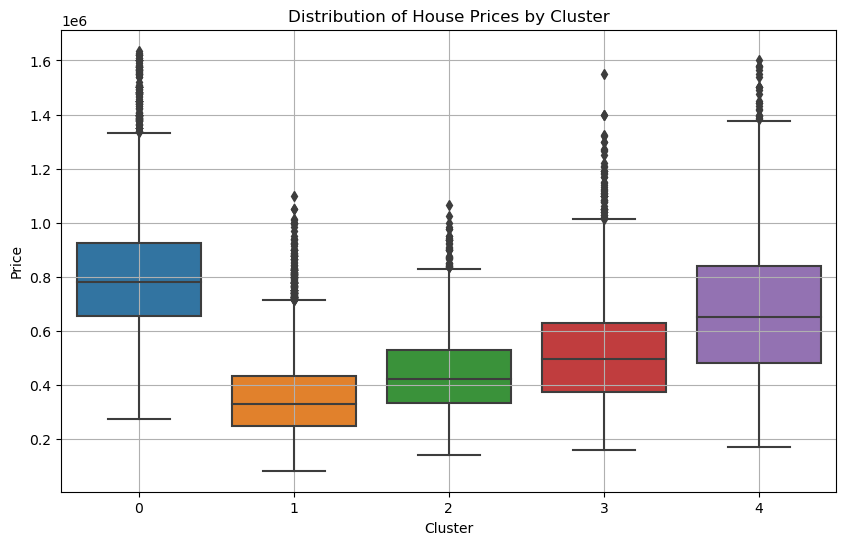

In [14]:
import seaborn as sns

# Plot price distribution for each cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='price', data=houses_df)
plt.title('Distribution of House Prices by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Price')
plt.grid(True)
plt.show()


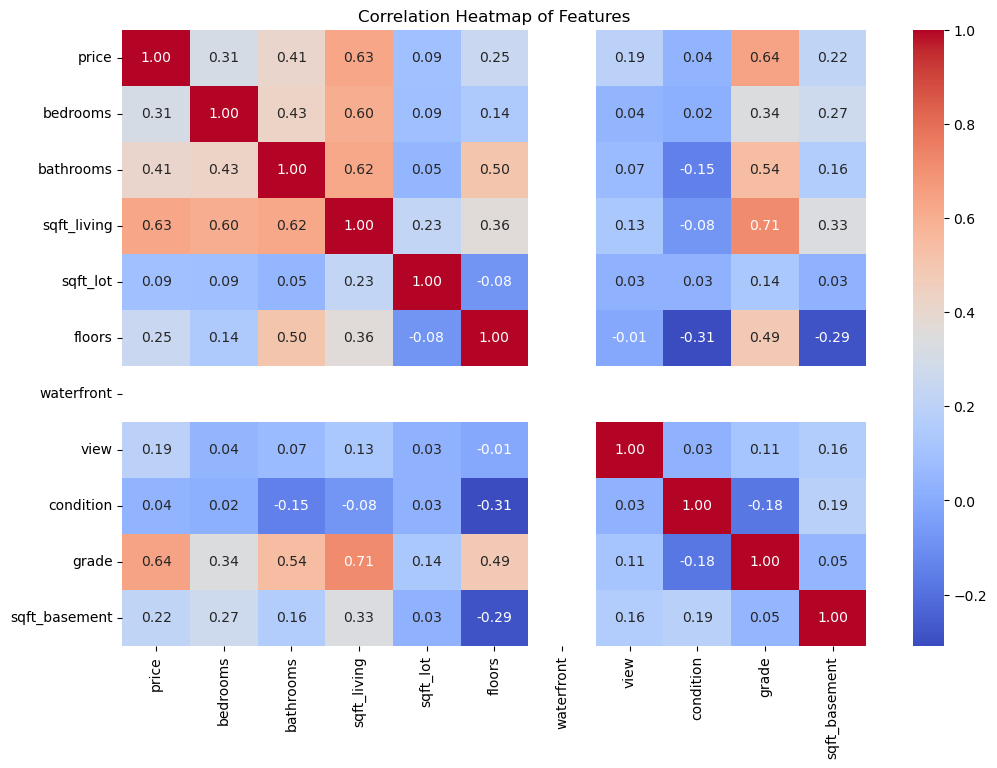

In [15]:
import matplotlib.pyplot as plt

corr_matrix = houses_df[features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()


In [ ]:
#checking for imbalance

houses_df['price_category'] = (houses_df['price'] >= houses_df['price'].median()).astype(int)

count_above_median = houses_df[houses_df['price_category'] == 1].shape[0]

count_below_median = houses_df[houses_df['price_category'] == 0].shape[0]

print(f"Class Above Median {count_above_median}")
print(f"Class below Median {count_below_median}")

In [18]:
#applying Apriori

features_to_categorize = ['grade', 'sqft_living', 'bathrooms', 'bedrooms', 'price_category']
apriori_dataset = houses_df[['id'] + features_to_categorize  ].head(15).copy()

# formatting the dataset for apriori
def categorize_feature(feature_values,feature):
    avg_value = feature_values.mean()
    return feature_values.apply(lambda x: f"Low {feature}" if x < avg_value else f"High {feature}")



for feature in features_to_categorize:
    apriori_dataset[feature] = categorize_feature(houses_df[feature],feature)

#combine all features in one list for each house
apriori_dataset['description'] = apriori_dataset[features_to_categorize].apply(lambda row: row.tolist(), axis=1)

#list of lists
Transactions = apriori_dataset['description'].tolist()



In [19]:
#apriori step by step
from itertools import combinations

frequent_itemset=[] #this list will keep track of frequent itemsets "exceeds min_support"
support_set=[]      #this list will keep track of support of each frequent set
min_support = 0.33

#function to check for min-support
def check_min_suppot (combi_x,frequent_itemset):

    #modigying the data type to safely used issubset() method by converting individual strings in level 1, and lists in all the other levels.
    for itemset in combi_x:
        if isinstance(itemset, str):
            itemset = {itemset}
        else:
            itemset = set(itemset)

        count = 0
        for transaction in Transactions:
            if itemset.issubset(transaction):
                count += 1
        if count >= min_support:
            frequent_itemset.append(itemset)
            support_set.append(count)

#level-1
unique_items = []
for t in Transactions:
    for item in t:
        if item not in unique_items:
            unique_items.append(item)
check_min_suppot(unique_items,frequent_itemset)

#create all possible itemset up to the length of our first "transaction", which is # of features for each house 
for x in range(2, len(Transactions[0]) + 1 ):
    combi_x = list(combinations(unique_items, x))
    check_min_suppot(combi_x,frequent_itemset)


rules = []
#generate all possible rules
for i, itemset in enumerate(frequent_itemset):
    if len(itemset) < 2:
        continue  
        
    for num in range(1, len(itemset)):
        for left in combinations(itemset, num):
            left = set(left)
            right = itemset - left

            # Calculate support, confidence, and lift
            support_itemset = support_set[i]
            support_left = support_set[frequent_itemset.index(left)]
            support_right = support_set[frequent_itemset.index(right)]
            confidence = support_itemset / support_left

            rule = {
                'left': left,
                'right': right,
                'support': support_itemset / len(Transactions),
                'confidence': confidence,
            }
            rules.append(rule)

# Step 3: Print all rules
for rule in rules:
    if rule['support'] > min_support:
        print(f"{rule['left']} --> {rule['right']}")
        print(f"Support: {rule['support']:.2f}, Confidence: {rule['confidence']:.2f}")
        print("-----") 



{'Low sqft_living'} --> {'Low grade'}
Support: 0.80, Confidence: 0.92
-----
{'Low grade'} --> {'Low sqft_living'}
Support: 0.80, Confidence: 0.86
-----
{'Low grade'} --> {'Low bathrooms'}
Support: 0.53, Confidence: 0.57
-----
{'Low bathrooms'} --> {'Low grade'}
Support: 0.53, Confidence: 1.00
-----
{'Low grade'} --> {'Low bedrooms'}
Support: 0.73, Confidence: 0.79
-----
{'Low bedrooms'} --> {'Low grade'}
Support: 0.73, Confidence: 0.92
-----
{'Low grade'} --> {'Low price_category'}
Support: 0.60, Confidence: 0.64
-----
{'Low price_category'} --> {'Low grade'}
Support: 0.60, Confidence: 1.00
-----
{'Low grade'} --> {'High bathrooms'}
Support: 0.40, Confidence: 0.43
-----
{'High bathrooms'} --> {'Low grade'}
Support: 0.40, Confidence: 0.86
-----
{'High price_category'} --> {'Low grade'}
Support: 0.33, Confidence: 0.83
-----
{'Low grade'} --> {'High price_category'}
Support: 0.33, Confidence: 0.36
-----
{'Low sqft_living'} --> {'Low bathrooms'}
Support: 0.53, Confidence: 0.62
-----
{'Low 